# DoWhy: Interpreters for Causal Estimators


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.206802,-1.258885,-2.374369,0.792148,0.816480,-1.517802,False,-9.096988
1,0.0,0.244381,-0.623885,0.141327,1.450525,1.318768,-1.171481,True,10.784996
2,0.0,0.122629,-2.190057,-2.055690,1.015255,-0.362669,-0.065213,False,-11.409103
3,1.0,0.923063,-0.931727,0.590025,-1.231453,0.461337,-0.302302,True,5.264218
4,0.0,0.987759,-1.374512,-0.712765,-0.228435,1.048379,-0.295109,True,5.467165
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.209009,-0.793358,-1.641863,-1.674486,-0.378895,-1.564938,False,-14.696441
9996,0.0,0.119268,-0.985182,-1.012306,-0.419466,-0.326704,-1.012925,False,-10.513265
9997,0.0,0.535492,-0.659344,0.334075,-1.391356,0.397139,-0.353148,False,-4.606079
9998,0.0,0.022868,0.433303,1.276208,-0.109367,0.231559,0.044190,True,14.182805


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

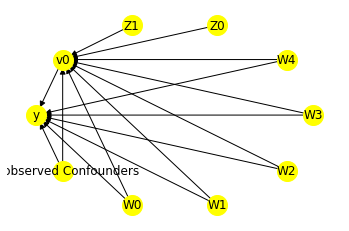

In [5]:
model.view_model()

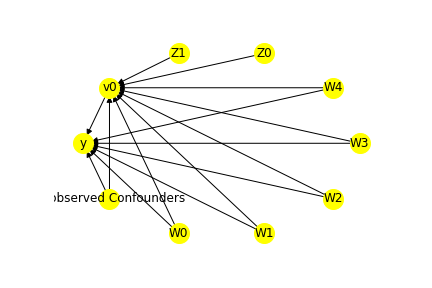

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done.

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Method 1: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [8]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

/home/sid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W4+W2
Target units: att

## Estimate
Mean value: 10.072895157255362

Causal Estimate is 10.072895157255362


In [17]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 10.072895157255362 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


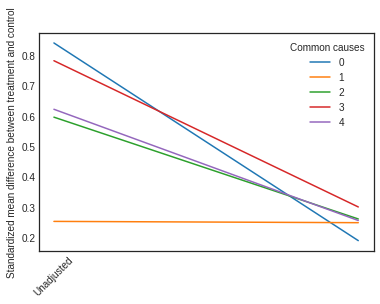

In [26]:
# Visual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="propensity_balance_interpreter")

## Method 2: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [18]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/home/sid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W4+W2
Target units: atc

## Estimate
Mean value: 10.056637352648954

Causal Estimate is 10.056637352648954


In [23]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 10.056637352648954 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


Cannot use propensity balance interpretor here since the interpreter method only supports propensity score stratification estimator.